# Using the Iris Dataset to Visualize Vectors
*Author:* Phil Miesle, [DataStax](https://www.datastax.com/products/vector-search), phil.miesle@datastax.com

## Objective
This objective of this notebook is to get you familiar with techniques that can be used to visualize high-dimesionality vectors, and uses the [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). 

1. Import Iris dataset and visulaize with standard plotting techniques
2. Review of how Vectors can be used to compare high-dimensionality data
3. The t-SNE technique, projecting down into two and three dimensions

## Setup
This notebook was created using Python 3.11, and the packages referenced in [requirements.txt](requirements.txt).

## Credits
The following resources were consulted in the creation of this notebook:
* [Python Data Visualizations](https://www.kaggle.com/code/benhamner/python-data-visualizations)
* [PCA vs T-SNE on Iris](https://www.kaggle.com/code/buiquangbao/pca-vs-t-sne-on-iris)


## Import and Review Data

![picture of three species of iris, with diagram showing where the sepal and petal ar](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

The sample dataset comprises of 150 irises, measuring the dimensions of the sepal and petal along with the species of each:

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets  

data = datasets.load_iris()
features, species_index, column_names = data['data'], data['target'], data['feature_names']
species = np.array([data['target_names'][i] for i in species_index])

iris = pd.DataFrame(features, columns = column_names)
iris['species'] = species

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


There are 50 examples of each of three species:

In [2]:
iris["species"].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Finally, we can do a basic visualization of the data using Pandas's built-in plotting functions:

<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

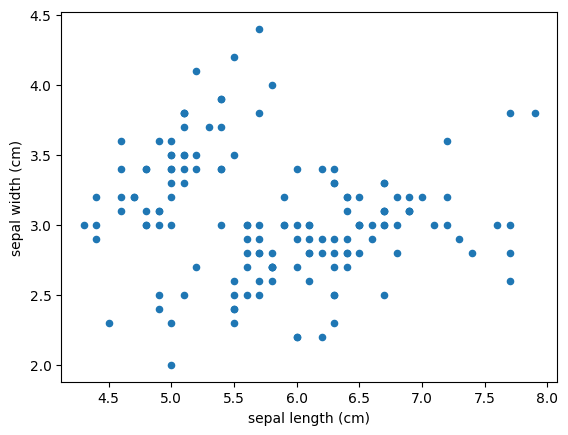

In [3]:
iris.plot(kind="scatter", x="sepal length (cm)", y="sepal width (cm)")

This is fairly limited; let's next explore the data using other plotting techniques.

## Basic Plots with Other Graphing Libraries


### Seaborn

The Seaborn `jointplot` can give us both the scatter plot and histogram in the same figure:

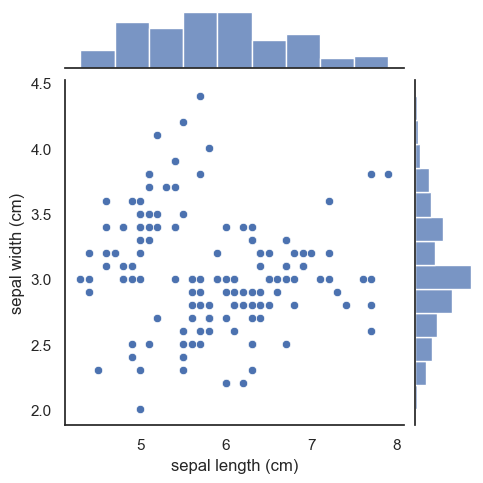

In [4]:
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white", color_codes=True)

sns.jointplot(x="sepal length (cm)", y="sepal width (cm)", data=iris, height=5)

Having a histogram is nice, it helps us undertand the variations overall within the data set. We can use the `FacetGrid` to add species labels to the plot (once we add in `pyplot`):

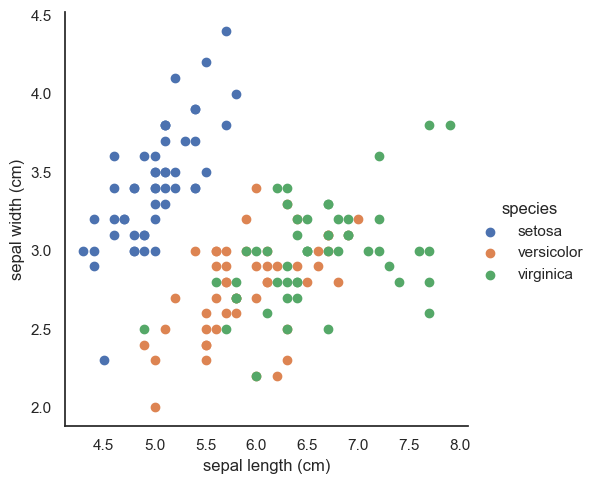

In [5]:
import matplotlib.pyplot as plt

sns.FacetGrid(iris, hue="species", height=5) \
   .map(plt.scatter, "sepal length (cm)", "sepal width (cm)") \
   .add_legend()

Ah, and now we can see there is a grouping of sepal widths and lengths by species! But this is just sepal length and width -- are there other relationships?

## Plotting More Relationships

We're starting to visualize some structure (by species) in the dataset, but this is in only one pair of measurements. Is there structure on other pairings? The Seaborn library provides a `pairplot` which can show the relationships between pairs of variables, allowing us to see correlations between pairs of features:

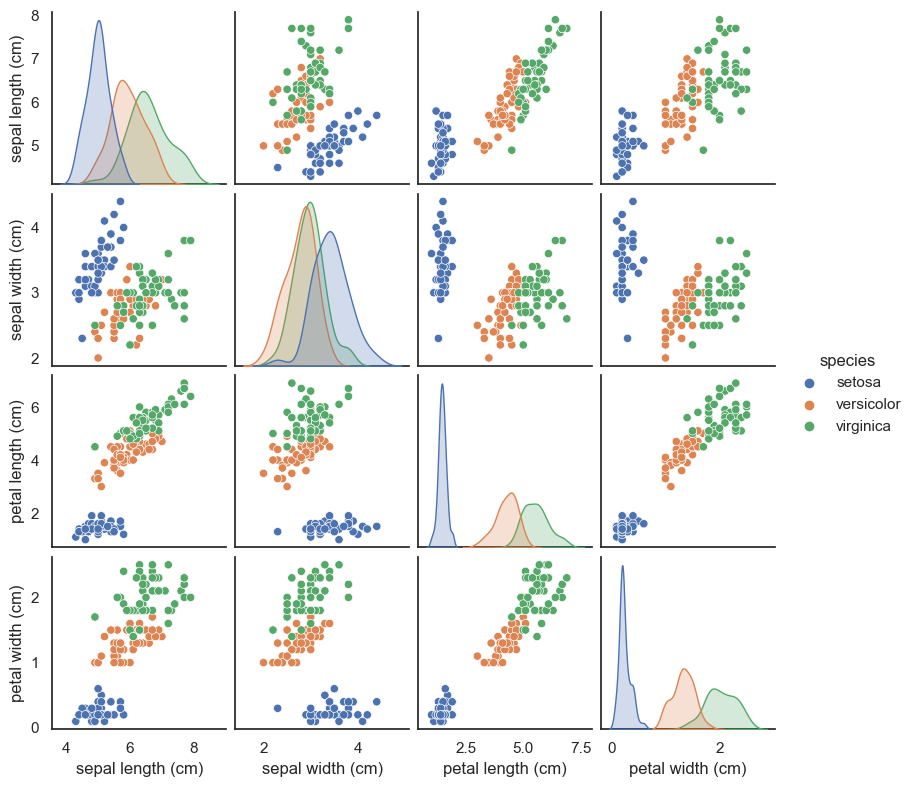

In [6]:
sns.pairplot(iris, hue="species", size=2)

The `pairplot` gives us some an even clearer understanding that there are pariwise groupings by species, but this required our human brain and its ability to recognize patterns. Furthermore, how easy would it be to interpret a `pairplot` with 10, 20, 200, or even more features? Such a plot would be overwhelming!

How can we help a computer do the same thing?

## Iris Data as Vectors

Now that we've visualized this dataset in two dimensions, comparing each dimension to the other, let's think about what this dataset would be in the context of a vector. What "dimensions" do we have within this dataset? That is really the same question as "what 'features' do we have within this dataset?". These are the things that we have directly measured and recorded about each iris (lengths and widths) rather than our classification (species). Let's examine our data frame:

In [7]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


We have the `species` column (the label, of which we know we have three distinct values), and then four columns of measurements, each of type `float64`. 

On other words, we have some metadata (`species`) and then four measurments (Septal and Petal, Length and Width). From our exploration above, we know that the measurements are not normalized - that is, they are not between `-1` and `1` (or `0` and `1`):

In [8]:
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We could therefore think of our dataset as having four features, and represent each of these features as dimensions within a 4-dimensional vector. When we loaded the data at the top of this notebook, we cleverly called this array `features`:

In [9]:
print(features[0:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


This is a list of four-dimensional `float64`s - otherwise known as a vector!

## Vector Similarity

Using a technique known as [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), we can compare the how similar (close) two vectors are to each other. The cosine similarity is a measure of the angle between two vectors - this is a "supercharged" version of what you learned in trigonometry. Explaining how this works is beyond the scope of this notebook, but there are some good explainers out there including [Cosine Similarity, Clearly Explained!!!](https://www.youtube.com/watch?v=e9U0QAFbfLI) from Josh Starmer (warning: there's some questionable singing at the start of his videos!).

Let's compute the cosine similarity for one setosa example to another, and then the setosa example compared to some versicolor examples:

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Pick two specific examples of 'setosa'
example_setosa1 = iris[iris['species'] == 'setosa'].iloc[0, :-1].values.reshape(1, -1)
example_setosa2 = iris[iris['species'] == 'setosa'].iloc[1, :-1].values.reshape(1, -1)

# Compute and display cosine similarity between the two setosa examples
similarity_setosa = cosine_similarity(example_setosa1, example_setosa2)
print(f"Cosine similarity between setosa example 1 and setosa example 2: {similarity_setosa[0][0]}")

# Pick the first 5 examples of 'versicolor'
versicolor_examples = iris[iris['species'] == 'versicolor'].iloc[:5, :-1]

# Compute and display cosine similarity for each of the 5 versicolor examples
for i, example in versicolor_examples.iterrows():
    example_versicolor = example.values.reshape(1, -1)
    similarity = cosine_similarity(example_setosa1, example_versicolor)
    print(f"Cosine similarity between example setosa and versicolor example {i}: {similarity[0][0]}")


Cosine similarity between setosa example 1 and setosa example 2: 0.9985791635040219
Cosine similarity between example setosa and versicolor example 50: 0.928380358714912
Cosine similarity between example setosa and versicolor example 51: 0.9259860598501765
Cosine similarity between example setosa and versicolor example 52: 0.9176636453871241
Cosine similarity between example setosa and versicolor example 53: 0.9064009690312
Cosine similarity between example setosa and versicolor example 54: 0.9134577018761825


With this, we can understand that we can compare one vector to another: our two setosa examples have a cosine similarity of 0.999 to each other, whereas the setosa and versicolor examples have a cosine similarity of around 0.91. Good to know, but lists of numbers are not very easy to visualize.

## Visualizing a High-Dimensional Dataset

It's great that the computer can now compare two vectors with arbitrarily high dimensionality, but can we use that to help visualize the data in a single plot? Of course we can! Two commonly used tecniques are PCA and t-SNE (there are others such as UMAP). You can explore this [Kaggle notebook](https://www.kaggle.com/code/agsam23/pca-vs-t-sne) to explore the differences between these two, but for this notebook we'll use t-SNE as it helps in visualizing small (local) structure. 

t-SNE is a machine learning algorithm that reduces the complexity of your data, making it easier to visualize by grouping similar data points together in a 2D or 3D space. It's particularly useful for understanding how data points relate to each other when you have lots of variables that make it hard to see these relationships directly. It works by calculating the probability that pairs of data points in the high-dimensional space are similar and then aims to recreate these probabilities as faithfully as possible in a lower-dimensional space, typically 2D or 3D, using gradient descent to minimize the difference between these probabilities. 

You can learn more about how t-SNE works in YouTube video [StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM).

### Two-Dimensional t-SNE Projection

The t-SNE algorithm is iterative, and the exact results can vary depending on the parameters used. Here, we will set a random seed value `123` and start at a "random" vector:

In [11]:
from sklearn.manifold import TSNE

# Define the t-SNE
random_seed=123
tsne2d = TSNE(n_components=2, random_state=random_seed, verbose=1, init='random')
# Fit to all rows and columns but the last one (species) as that is not a feature
features_tsne2d = tsne2d.fit_transform(iris.iloc[:, :-1]) 

df_tsne2d = pd.DataFrame(features_tsne2d)
df_tsne2d.rename(columns = {0:'comp-1', 1:'comp-2'}, inplace = True)
df_tsne2d['species'] = species

df_tsne2d.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...


  File "c:\Users\Phil\git\VectorMoreThanText\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[t-SNE] Computed neighbors for 150 samples in 0.219s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.509910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.411346
[t-SNE] KL divergence after 1000 iterations: 0.125280


,comp-1,comp-2,species
0,8.967126,-18.541664,setosa
1,10.012585,-21.092762,setosa
2,8.888903,-20.990015,setosa
3,9.288636,-21.424271,setosa
4,9.090508,-18.536165,setosa


As we now have a familiar-looking 2-dimensional dataset, we can use the same plotting techniques we used above to visualize the data:

[Text(0.5, 1.0, 'Iris data 2D t-SNE projection (random seed: 123)')]

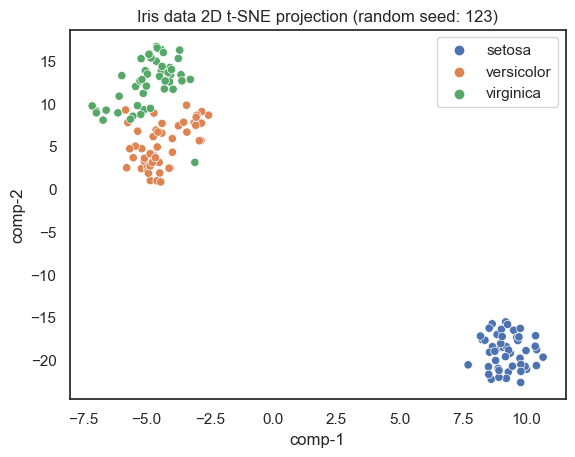

In [12]:
sns.scatterplot(
  data=df_tsne2d,
  hue = df_tsne2d['species'].tolist(),
  x = "comp-1", y = "comp-2", 
).set(title=f"Iris data 2D t-SNE projection (random seed: {random_seed})")

Here, we can see very clear structure by species, and we can also see that the versicolor and virginica species are closer to each other than either is to the setosa species. While we understood this by looking at the `pairplot`, this is a single plot and we can see the structure in a single glance.

For fun, try to change the `random_seed` and see how the results differ.

### Three-Dimensional t-SNE Projection

t-SNE can be used to map into any number of dimensions, so let's try a 3-dimensional projection:

In [13]:
tsne3d = TSNE(n_components=3, random_state=random_seed, verbose=1, init='random')
features_tsne3d = tsne3d.fit_transform(iris.iloc[:, :-1]) 

df_tsne3d = pd.DataFrame(features_tsne3d)
df_tsne3d.rename(columns = {0:'comp-1', 1:'comp-2', 2:'comp-3'}, inplace = True)
df_tsne3d['species'] = species

df_tsne3d.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.509910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.281582
[t-SNE] KL divergence after 1000 iterations: 0.393192


,comp-1,comp-2,comp-3,species
0,0.754873,-10.380173,0.093464,setosa
1,-0.661162,-9.769817,2.399027,setosa
2,0.529600,-10.468375,2.571343,setosa
3,-0.364593,-11.252541,3.217187,setosa
4,1.105977,-11.196972,0.236596,setosa


To visualize this in 3D, we'll use the Plotly library, as it provides a means to interact with the plot - rotating, zooming, panning, tooltips, etc.:

In [14]:
import plotly.express as px

fig = px.scatter_3d(
    features_tsne3d, x=0, y=1, z=2,
    color=df_tsne3d.species, labels={'color': 'species'},
    color_discrete_sequence=px.colors.qualitative.D3
)
fig.update_layout(scene=dict(xaxis_title='comp-1', yaxis_title='comp-2', zaxis_title='comp-3'))
fig.update_traces(marker_size=3)
fig.show()

You can click and move the plot around - try combinations of mouse buttons and wheel and/or keyboard controls like Shift and Command or Control. There are also camera controls in the top right of the plot.

## In Conclusion

The projection dimensionality you choose for t-SNE is really up to you - it is a technique that helps you to understand the structure of the data. Having more dimensions may help better tease out the structure, but it can also make it harder to visualize!

We have looked at the Iris data using the `species` label, but your own vector data may well have more than one element of metadata. Hopefully this notebook has given you some ideas and techniques to help you visualize your own data.